In [0]:
import pandas as pd
import time
import seaborn as sns
import datetime
import numpy as np
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation, Dense
import requests

pd.set_option('float_format', '{:f}'.format)

In [0]:
SYM = 'BTC'
data = pd.read_csv(SYM+'HistData.csv')[29:].reset_index(drop=True)
data['time'] = pd.to_datetime(data['time']).dt.normalize()
data['Weighted_Price'] = (data['close'] + data['high'] +  data['low'] + data['open'] ) /4
del data['id']
del data['symbol']
data = data.reset_index(drop=True)
last_week_hist = data[-6:]

In [20]:
data.tail(5)

,time,close,high,low,open,volumefrom,volumeto,Weighted_Price
1517,2019-03-26,4045.979980,4054.320068,3932.790039,3942.219971,37132.400000,149005782.260000,3993.827515
1518,2019-03-27,4036.449951,4046.439941,4014.689941,4045.979980,25343.130000,102296341.190000,4035.889954
1519,2019-03-28,4111.379883,4122.890137,4031.219971,4036.449951,41843.310000,170915132.770000,4075.484985
1520,2019-03-29,4118.129883,4146.879883,4066.870117,4111.379883,24906.260000,102400533.820000,4110.814941
1521,2019-03-30,4110.810059,4129.430176,4108.140137,4118.129883,1974.760000,8138110.090000,4116.627563


In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


data.drop(['time'],inplace=True,axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

In [0]:
columns=data.columns

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	
	for i in range(n_in, 0, -1):
		cols.append(df.shift(-i))
		names += [(j) for j in columns]
	
	for i in range(0, n_out):
		cols.append(df.shift(i))
		if i == 0:
			names += [("output "+j) for j in columns]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
reframed = series_to_supervised(scaled, 1, 1)
ref=series_to_supervised(data.values,1,1)
ref.drop(ref.columns[[7,8,9,10,11,12]], axis=1, inplace=True)

In [24]:
reframed.drop(reframed.columns[[7,8,9,10,11,12]], axis=1, inplace=True)
print(reframed.head())

     close     high      low     open  volumefrom  volumeto  Weighted_Price  \
0 0.000370 0.000670 0.001089 0.001067    0.077904  0.000732        0.000622   
1 0.000724 0.000471 0.000725 0.000370    0.075983  0.000638        0.000396   
2 0.001434 0.001034 0.001308 0.000724    0.071818  0.000623        0.000951   
3 0.000835 0.001287 0.001490 0.001433    0.118474  0.001590        0.001088   
4 0.000792 0.000434 0.001292 0.000835    0.103280  0.001189        0.000659   

   output Weighted_Price  
0               0.001091  
1               0.000622  
2               0.000396  
3               0.000951  
4               0.001088  


In [25]:
values=reframed.values
train = values[9:1360, :]
test = values[1360:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1351, 1, 7) (1351,) (161, 1, 7) (161,)


Train on 1351 samples, validate on 161 samples
Epoch 1/50
 - 1s - loss: 0.0544 - val_loss: 0.0358
Epoch 2/50
 - 0s - loss: 0.0748 - val_loss: 0.0217
Epoch 3/50
 - 0s - loss: 0.0212 - val_loss: 0.0200
Epoch 4/50
 - 0s - loss: 0.0091 - val_loss: 0.0098
Epoch 5/50
 - 0s - loss: 0.0144 - val_loss: 0.0311
Epoch 6/50
 - 0s - loss: 0.0138 - val_loss: 0.0114
Epoch 7/50
 - 0s - loss: 0.0131 - val_loss: 0.0203
Epoch 8/50
 - 0s - loss: 0.0112 - val_loss: 0.0063
Epoch 9/50
 - 0s - loss: 0.0120 - val_loss: 0.0194
Epoch 10/50
 - 0s - loss: 0.0112 - val_loss: 0.0070
Epoch 11/50
 - 0s - loss: 0.0129 - val_loss: 0.0188
Epoch 12/50
 - 0s - loss: 0.0114 - val_loss: 0.0078
Epoch 13/50
 - 0s - loss: 0.0139 - val_loss: 0.0225
Epoch 14/50
 - 0s - loss: 0.0151 - val_loss: 0.0092
Epoch 15/50
 - 0s - loss: 0.0173 - val_loss: 0.0271
Epoch 16/50
 - 0s - loss: 0.0187 - val_loss: 0.0122
Epoch 17/50
 - 0s - loss: 0.0129 - val_loss: 0.0161
Epoch 18/50
 - 0s - loss: 0.0204 - val_loss: 0.0233
Epoch 19/50
 - 0s - loss: 

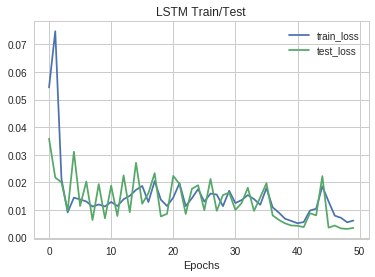

In [26]:

model = Sequential()
model.add(LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.title('LSTM Train/Test')
pyplot.show()
pyplot.show()

In [0]:
model.save(SYM+'model.h5')

In [28]:

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse =sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 93.315


In [29]:

data_pred=np.array([[4110.810059,4129.430176,4108.140137,4118.129883,1974.76,8138110.090000	,4116.627563]])

print(data_pred.shape[0])
a=scaler.fit_transform(data_pred)
pre=model.predict(a.reshape(data_pred.shape[0],1,7))
phat=np.concatenate((pre,a[:,1:]),axis=1)
predicted=scaler.inverse_transform(phat)
print(predicted)


predicted_weight=[]
date=[]
difference=[]
pr_change=[]
date=pd.date_range('31-03-2019','31-03-2019',freq='D').sort_values(ascending=False)

for i in range(data_pred.shape[0]):
    predicted_weight.append(predicted[i,0])

df=pd.DataFrame({'Date':date})
df['Weighted_Price']=predicted_weight
print(df)

1
[[4.11080886e+03 4.12943018e+03 4.10814014e+03 4.11812988e+03
  1.97476000e+03 8.13811009e+06 4.11662756e+03]]
        Date  Weighted_Price
0 2019-03-31     4110.808864


In [30]:
last_week_hist

,time,close,high,low,open,volumefrom,volumeto,Weighted_Price
1516,2019-03-25,3942.219971,3943.199951,3902.520020,3924.550049,23873.140000,93805733.550000,3928.122498
1517,2019-03-26,4045.979980,4054.320068,3932.790039,3942.219971,37132.400000,149005782.260000,3993.827515
1518,2019-03-27,4036.449951,4046.439941,4014.689941,4045.979980,25343.130000,102296341.190000,4035.889954
1519,2019-03-28,4111.379883,4122.890137,4031.219971,4036.449951,41843.310000,170915132.770000,4075.484985
1520,2019-03-29,4118.129883,4146.879883,4066.870117,4111.379883,24906.260000,102400533.820000,4110.814941
1521,2019-03-30,4110.810059,4129.430176,4108.140137,4118.129883,1974.760000,8138110.090000,4116.627563


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("whitegrid")
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


last_week_hist.set_index('time', inplace=True)

last_week_hist


,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-03-25,3942.219971,3943.199951,3902.520020,3924.550049,23873.140000,93805733.550000,3928.122498
2019-03-26,4045.979980,4054.320068,3932.790039,3942.219971,37132.400000,149005782.260000,3993.827515
2019-03-27,4036.449951,4046.439941,4014.689941,4045.979980,25343.130000,102296341.190000,4035.889954
2019-03-28,4111.379883,4122.890137,4031.219971,4036.449951,41843.310000,170915132.770000,4075.484985
2019-03-29,4118.129883,4146.879883,4066.870117,4111.379883,24906.260000,102400533.820000,4110.814941
2019-03-30,4110.810059,4129.430176,4108.140137,4118.129883,1974.760000,8138110.090000,4116.627563


In [32]:
last_week_hist.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [33]:
last_week_hist = last_week_hist.reset_index().rename(columns={'time': 'Date'})
verticalStack = pd.concat([last_week_hist, df], axis=0)
verticalStack

,Date,Weighted_Price
0,2019-03-25,3928.122498
1,2019-03-26,3993.827515
2,2019-03-27,4035.889954
3,2019-03-28,4075.484985
4,2019-03-29,4110.814941
5,2019-03-30,4116.627563
0,2019-03-31,4110.808864


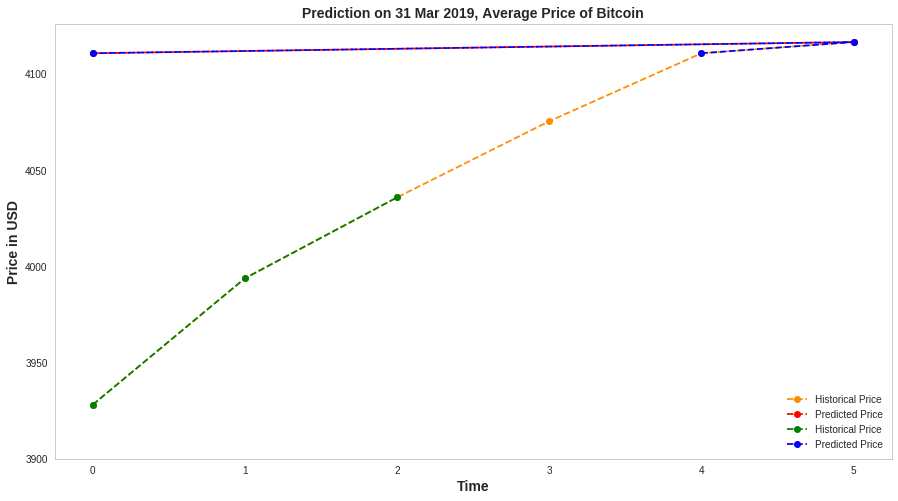

In [34]:
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

verticalStack

plt.figure(figsize=(15,8))
(verticalStack['Weighted_Price'][0:6]).plot(color='darkorange', label='Historical Price', linestyle='--', marker='o')
(verticalStack['Weighted_Price'][5:]).plot(color='red', label='Predicted Price',linestyle='--', marker='o')
(verticalStack['Weighted_Price'][0:3]).plot(color='green', label='Historical Price', linestyle='--', marker='o')
(verticalStack['Weighted_Price'][4:]).plot(color='blue', label='Predicted Price',linestyle='--', marker='o')

plt.ylim(bottom=3900)
plt.grid()
plt.xlabel('Time', fontweight='bold',fontsize=14)
plt.ylabel('Price in USD', fontweight='bold',fontsize=14)
plt.title('Prediction on 31 Mar 2019, Average Price of Bitcoin', fontweight='bold',fontsize=14)
plt.legend()
plt.show()